In [1]:
import os, getpass
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.tools.retriever import create_retriever_tool
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
from langgraph.graph import MessagesState
from typing import Literal
import gradio as gr

In [2]:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

In [3]:
embedding = OpenAIEmbeddings()

In [23]:
vectorstore = Chroma(persist_directory=f"../db/rag_db", embedding_function=embedding)
vector_store_excel = Chroma(persist_directory=f"../db/excel_db", embedding_function=embedding)

In [24]:
retriever = vectorstore.as_retriever()
retriever_exel = vector_store_excel.as_retriever()

In [25]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_employee_blog",
    "Search and return information about Employee blog posts.",
)

retriever_tool_excel = create_retriever_tool(
    retriever_exel,
    "retrieve_worldwide_information",
    "Search and return information about worldwide information.",
)

In [26]:
retriever_tool.invoke({"query": "Who is Alex Chen"})

'## Other HR Notes\n- Participates regularly in Insurellm\'s Diversity & Inclusion initiatives, championing tech accessibility for underrepresented communities.\n- Completed several certifications in cloud architecture and DevOps, contributing to professional growth.\n- Plans for a professional development course in AI and machine learning to further enhance backend capabilities in Insurellm\'s offerings.\n- Acknowledged for volunteer efforts in local tech meetups, bringing seasoned engineers to mentor aspiring coders.  \n\nAlex Chen continues to be a vital asset at Insurellm, contributing significantly to innovative backend solutions that help shape the future of insurance technology.\n\n# HR Record\n\n# Alex Chen\n\n## Summary\n- **Date of Birth:** March 15, 1990  \n- **Job Title:** Backend Software Engineer  \n- **Location:** San Francisco, California  \n\n## Insurellm Career Progression\n- **April 2020:** Joined Insurellm as a Junior Backend Developer. Focused on building APIs to e

In [28]:
retriever_tool_excel.invoke({"query": "min pdgPercap of Canada"})

'Unnamed: 0: 240, country: Canada, continent: Americas, year: 1952, lifeExp: 68.75, pop: 14785584, gdpPercap: 11367.16112, iso_alpha: CAN, iso_num: 124\n\nUnnamed: 0: 251, country: Canada, continent: Americas, year: 2007, lifeExp: 80.653, pop: 33390141, gdpPercap: 36319.23501, iso_alpha: CAN, iso_num: 124\n\nUnnamed: 0: 242, country: Canada, continent: Americas, year: 1962, lifeExp: 71.3, pop: 18985849, gdpPercap: 13462.48555, iso_alpha: CAN, iso_num: 124\n\nUnnamed: 0: 243, country: Canada, continent: Americas, year: 1967, lifeExp: 72.13, pop: 20819767, gdpPercap: 16076.58803, iso_alpha: CAN, iso_num: 124'

In [111]:
arr_rag_tool = [retriever_tool, retriever_tool_excel]

In [29]:
grade_prompt = (
    "Use the information below to answer the user's question. "
    "If you can't find a suitable answer, just say you don't know. "
    "Don't give wrong or incorrect answers. "
    "{context} "
    "Câu hỏi: {question} "
)

In [30]:
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

In [31]:
grader_model = init_chat_model("openai:gpt-4o-mini", temperature=0)

In [90]:
def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    system_message = {
    "role": "system",
    "content": (
        "You are an assistant who only answers based on the tools provided."
        "If unsure, or not given the appropriate data, "
        "reply: 'The question is beyond the scope of information I have access to.' "
        "Absolutely do not speculate or make up information."
    )
}
    print(f"generate_query_or_respond")
    response = (
        grader_model
        .bind_tools(arr_rag_tool).invoke([system_message] + state["messages"])
    )
    return {"messages": [response]}

In [91]:
def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = grade_prompt.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score
    print(f"grade_documents:{score}")
    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [93]:
rewrite_prompt = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

In [94]:
def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    print("rewrite_question")
    messages = state["messages"]
    question = messages[0].content
    prompt = rewrite_prompt.format(question=question)
    response = grader_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [95]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    print("generate_answer")
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = grader_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [96]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


In [97]:
def tool_rag_node():
    print("tool_rag_node")
    return ToolNode(arr_rag_tool)

In [113]:
workflow = StateGraph(MessagesState)

In [114]:
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", tool_rag_node())
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")
graph = workflow.compile(name="rag_lang_graph")

tool_rag_node


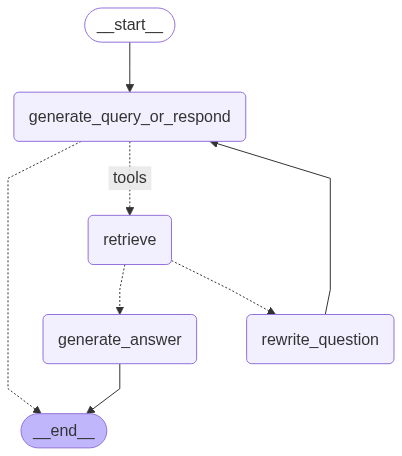

In [115]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [116]:
response = graph.invoke({
        "messages": [
            {
                "role": "user",
                "content": "Summarize data of Canada",
            }
        ]
    })
response["messages"][-1].content

generate_query_or_respond
grade_documents:yes
generate_answer


'Canada, located in the Americas, had a population of approximately 33.39 million in 2007, with a life expectancy of 80.65 years and a GDP per capita of about $36,319. In 1977, the population was around 23.80 million, with a life expectancy of 74.21 years and a GDP per capita of approximately $22,091. Over the decades, Canada has seen improvements in life expectancy and GDP per capita.'